
<center>

# **DATA PRE-PROCESSING / FEATURE ENGINEERING** 

By: Ly Nguyen 

</center>

**- Exploratory data analysis**

- Assess min, max, quantiles, standard deviations of features
- Assess class imbalance
- Assess outliers 

**- Data Pre-processing:**

- Handle any NULL values, missing values, NA values, and zeros. 

- Select the response variable and the predictors:
    - Predictors:
        - Day (7 categories: Monday -> Sunday)

        - Holiday (12 unique values)

        - Season (7 categories: Spring 2023, Summer 2023, Autumn 2023, Winter 2023, Spring 2024, Summer 2024, Autumn 2024). 
        
            (*Note: the dataset is from Jan 2023 to Sep 2024 only.) 

        - Time (4 categories: morning peak (06:30 - 09:30), midday (10:00 - 14:00), evening peak (16:30 - 19:00), off peak (others))

        

        - Line (19 unique values)

        - Location (~3,000 unique locations)

        - Bound (4 unique categories: N, S, W, E)

        - Vehicle (~2,000 unique vehicle numbers)

        - Incident category (13 categories)


    - Response variable:
        - Delay time (3 categories: short delay (5 minutes or less), normal delay (between 6 and 15 minutes), long delay (16 minutes or more)) 

- Use Statistical Inference with visualization tools: 

    - Handle significant outliers 
    
- Feature engineering:
    - 'One hot encode' the features (over 4,300 features) 
    
    

# *EXPLORATORY ANALYSIS (EDA)* 


In [1]:
# Import necessary libraries for this notebook: 

# Read from SQLite database and load to a pandas dataframe
import os
import sqlite3
import pandas as pd

# For using arrays 
import numpy as np

# For data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# For saving the model into a pkl file
import joblib


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load the saved df_prelim parquet file: 
relative_path = os.path.join("..", "data", "df_prelim.parquet")
df = pd.read_parquet(relative_path)


In [3]:
# Assess datatype and any NULL values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  21742 non-null  datetime64[ns]
 1   line           21698 non-null  object        
 2   incident_time  21742 non-null  object        
 3   day_of_week    21742 non-null  object        
 4   location       21741 non-null  object        
 5   incident       21742 non-null  object        
 6   min_delay      21742 non-null  int64         
 7   min_gap        21742 non-null  int64         
 8   bound          19127 non-null  object        
 9   vehicle        21742 non-null  object        
 10  holidayType    502 non-null    object        
 11  seasonType     21742 non-null  object        
 12  lineId         21580 non-null  object        
 13  lineName       21580 non-null  object        
 14  delayType      21742 non-null  int64         
dtypes: datetime64[ns](1

*Comment:*

-The dataset `df` contains 21,742 entries. 

1. **Null Values**:
   - Several columns contain null values:
     - `line` has 44 null values.
     - `location` has 1 null value.
     - `bound` has a significant number of null values (2,615).
     - `holidayType` has many null values, with only 502 non-null entries.
     - `lineId` and `lineName` also have null values (162 each).

2. **Data Types**:
   - `incident_date` is correctly in `datetime64[ns]` format.
   - `min_delay`, `min_gap`, and `delayType` are correctly in numerical integer formats.  
   - The rest is correctly stored as `object` format. 



*Note:* 

- When TTC streetcars are out of service and buses are used as substitutes, these buses are typically assigned the same route number as the streetcar line they are replacing. This helps passengers easily identify the substitute service and understand that it follows the same route as the regular streetcar service.

- For example, if a streetcar on route 509 Harbourfront is out of service, a bus might be assigned route number 509 to continue providing service along the same path.

- Therefore, we can drop the null values in 'line'.


In [4]:
# Count the unique values of each of the features
df.nunique()

incident_date     639
line               44
incident_time    1439
day_of_week         7
location         3197
incident           14
min_delay         268
min_gap           292
bound               8
vehicle          1578
holidayType         9
seasonType          8
lineId             17
lineName           12
delayType           3
dtype: int64

In [5]:
# Let's see why 'bound' has 8 unique values when it should only have 4 (N, S, W, E)
df['bound'].unique()


array(['W', 'E', 'S', None, 'N', 'B', '`', '1', '8'], dtype=object)

In [6]:
# Define the allowed values
allowed_bounds = ['N', 'S', 'W', 'E']

# Filter the DataFrame to keep only rows where 'bound' is in the allowed list
df = df[df['bound'].isin(allowed_bounds)]

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
df['bound'].unique()


array(['W', 'E', 'S', 'N'], dtype=object)

In [7]:
# Drop rows with null values in any column except 'holidayType'
df = df.dropna(subset=[col for col in df.columns if col != 'holidayType'])

# Confirm the remaining rows and null counts
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 18985 entries, 0 to 19108
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  18985 non-null  datetime64[ns]
 1   line           18985 non-null  object        
 2   incident_time  18985 non-null  object        
 3   day_of_week    18985 non-null  object        
 4   location       18985 non-null  object        
 5   incident       18985 non-null  object        
 6   min_delay      18985 non-null  int64         
 7   min_gap        18985 non-null  int64         
 8   bound          18985 non-null  object        
 9   vehicle        18985 non-null  object        
 10  holidayType    436 non-null    object        
 11  seasonType     18985 non-null  object        
 12  lineId         18985 non-null  object        
 13  lineName       18985 non-null  object        
 14  delayType      18985 non-null  int64         
dtypes: datetime64[ns](1), in

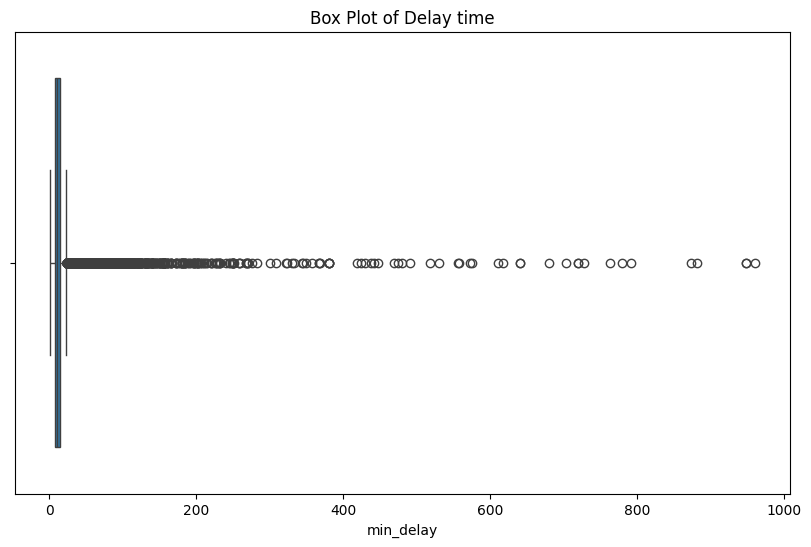

In [8]:
# Check for class imbalance with data visualization

# Whisker plot 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['min_delay'])
plt.title('Box Plot of Delay time')
plt.show()

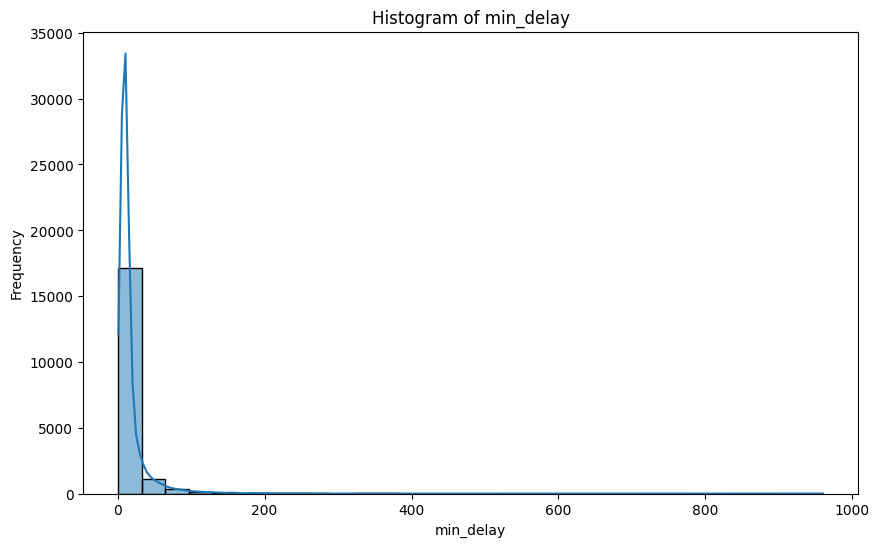

In [9]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['min_delay'], bins=30, kde=True)
plt.title('Histogram of min_delay')
plt.xlabel('min_delay')
plt.ylabel('Frequency')
plt.show()

In [10]:
# View the largest min_delay values - which are most likely outliers 
df['min_delay'].nlargest(20)


4744     960
4530     948
4550     948
4506     882
16055    873
15955    792
4761     780
170      763
4240     728
3018     720
3972     720
18556    703
15956    680
4421     641
13218    640
5351     618
15680    611
1020     575
5737     573
14167    558
Name: min_delay, dtype: int64

In [12]:
# Save df as "df_EDA" parquet file in 'data' folder (for separate EDA)
relative_path = os.path.join("..", "data", "df_EDA.parquet")
df.to_parquet(relative_path, index=False)



### *Note:*

**Exploratory Data Analysis (EDA):** 

- Please refer to the EDA.ipynb for the visualizations.

- After exploring several 'number of classes' (between 2 to 6 classes) and 'delay buckets' (varying between 10 minutes and 20 minutes), and fitting a Random Forest Classifier on them:

- The optimal number of classes is 3, and the optimal 'delay buckets' are as follows:
  - Short delay (5 minutes or less)
  - Normal delay (between 6 and 15 minutes)
  - Long delay (16 minutes or more)

- This has been reflected accordingly in the "createLINETable.py" script, and consequently, the "streetcardelaydb2.db" database.

**Measurement Error and Recall Bias:**

- As observed in the EDA.ipynb file, there is likely significant recall bias in the data collection process, where it seems that data collectors/reporters estimated delay minutes rather than using a system/algorithm to 'start' and 'stop' the clock counts when a delay event occurs.
- For example, there are large volumes of exactly 5-minute, 10-minute, and 15-minute delays, with a notable drop in volumes for the minutes in between.
- We could verify this assumption with the TTC.
- If this is the case, it is also highly likely that many significantly long delays—up (to 15 hours) — may be due to recall bias rather than actual 'start' and 'stop' clock counts, exacerbating measurement error and reducing data quality.


**Approach:**

- Due to the recall bias and measurement error mentioned, using regression would most likely result in a poor fit, as it tries to accurately predict numbers from data that were likely roughly estimated.
- We will select a classification model and choose an ensemble bagging method for this problem — in particular, the Random Forest Classifier.




### **Observation:**

- Most of the delay time observations fall within 15 minutes (as shown in the boxplot).
- There are many outliers outside of 15 minutes, extending as far as 900 minutes.
- The data distribution is skewed to the right.
- We have several options to approach this case study:
  - Option 1: Focus the analysis on the most frequently encountered delays, i.e., within 15 minutes.
  - Option 2: Focus the analysis on the most disruptive and significant delays, i.e., above 600 minutes.
  - Option 3: Include all data points to have a general view and accept the possibility of a less accurate prediction.


**Approach:**

- For this project scope, we choose **Option 3: to have a general view, accepting the possibility of a less accurate prediction**.
- We try to minimize inaccuracies as much as possible for Option 3 by:
  - Using a classifier to define classes of 'frequent delays' (delays within 15 minutes) and 'disruptive/significant delays' (delays longer than 15 minutes), and employing a Random Forest Classifier as it is generally robust with outliers.
    - Delay Type 1 - Short delay: 5 minutes or less
    - Delay Type 2 - Normal delay: between 6 and 15 minutes
    - Delay Type 3 - Long delay: over 15 minutes

  - Reducing the dataset to delays that are less than 1 hour.

- (Remark: Option 1 and Option 2 are *out of scope* but can be studied separately in the future.)



In [13]:
# Create a new DataFrame with min_delay values less than 60 minutes
df_new = df[df['min_delay'] < 61]

# Display the new DataFrame
df_new.head()



,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,holidayType,seasonType,lineId,lineName,delayType
0,2023-01-01,505,02:40,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,New Year's Day,Winter 2023,505,Dundas,2
1,2023-01-01,504,02:52,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,New Year's Day,Winter 2023,504,King,2
2,2023-01-01,504,02:59,Sunday,KING AND BATHURST,Held By,25,35,E,4560,New Year's Day,Winter 2023,504,King,3
3,2023-01-01,510,05:38,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,New Year's Day,Winter 2023,510,Spadina,2
4,2023-01-01,501,08:52,Sunday,LAKE SHORE AND THIRTY,Cleaning - Unsanitary,10,20,W,8015,New Year's Day,Winter 2023,501,Queen,2


In [17]:
df_new.describe()

,incident_date,min_delay,min_gap,delayType
count,18234,18234.000000,18234.000000,18234.000000
mean,2023-11-18 08:59:18.538993152,12.878469,21.901338,2.086377
min,2023-01-01 00:00:00,1.000000,0.000000,1.000000
25%,2023-06-13 00:00:00,8.000000,16.000000,2.000000
50%,2023-11-25 00:00:00,10.000000,20.000000,2.000000
75%,2024-04-17 00:00:00,12.000000,21.000000,2.000000
max,2024-09-30 00:00:00,60.000000,224.000000,3.000000
std,NaN,9.842077,12.129825,0.540518


In [18]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18234 entries, 0 to 19108
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  18234 non-null  datetime64[ns]
 1   line           18234 non-null  object        
 2   incident_time  18234 non-null  object        
 3   day_of_week    18234 non-null  object        
 4   location       18234 non-null  object        
 5   incident       18234 non-null  object        
 6   min_delay      18234 non-null  int64         
 7   min_gap        18234 non-null  int64         
 8   bound          18234 non-null  object        
 9   vehicle        18234 non-null  object        
 10  holidayType    425 non-null    object        
 11  seasonType     18234 non-null  object        
 12  lineId         18234 non-null  object        
 13  lineName       18234 non-null  object        
 14  delayType      18234 non-null  int64         
dtypes: datetime64[ns](1), in

# DATA PRE-PROCESSING / FEATURE ENGINEERING

- Featurize the time types 
- Clean values within the reduced dataset 
- One-hot-encode the features 

In [19]:
# Ensure consistent parsing of datetime
df_new['incident_time'] = pd.to_datetime(
    df_new['incident_time'], 
    format='%H:%M',  # Adjust format based on time data (e.g., 'HH:MM')
    errors='coerce'
).dt.time

# Define function to categorize time
def categorize_time(time):
    if pd.isna(time):
        return None
    if pd.to_datetime('06:30').time() <= time <= pd.to_datetime('09:30').time():
        return 'morning_peak'
    elif pd.to_datetime('10:00').time() <= time <= pd.to_datetime('14:00').time():
        return 'midday'
    elif pd.to_datetime('16:30').time() <= time <= pd.to_datetime('19:00').time():
        return 'evening_peak'
    else:
        return 'off_peak'

# Apply function to create new column "timeType"
df_new = df_new.copy()  # Ensure df_new is independent
df_new['timeType'] = df_new['incident_time'].apply(categorize_time)

# Define a helper function for cleaning columns
def clean_column(df, column_name, valid_values=None):
    # Work on a copy of the DataFrame
    cleaned_df = df.copy()
    
    # Remove leading/trailing spaces
    cleaned_df.loc[:, column_name] = cleaned_df[column_name].str.strip()
    
    # Drop rows with null values in the specified column
    cleaned_df = cleaned_df[cleaned_df[column_name].notna()]
    
    # Filter rows by valid values if provided
    if valid_values:
        cleaned_df = cleaned_df[cleaned_df[column_name].isin(valid_values)]
    
    return cleaned_df

# Initialize df_cleaned as a copy of df_new
df_cleaned = df_new.copy()

# Clean columns
columns_to_clean = ['location', 'incident', 'vehicle', 'day_of_week', 'line', 'bound']
for col in columns_to_clean:
    df_cleaned = clean_column(df_cleaned, col)

# Recreate df_cleaned to ensure independence
df_cleaned = df_cleaned.copy()

# One-Hot Encode Categorical Columns
categorical_cols = ['location', 'incident', 'vehicle', 'day_of_week', 'line', 'bound', 'timeType', 'holidayType', 'seasonType']

# Use pandas get_dummies to one-hot encode the categorical columns
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)



In [20]:
# Display the DataFrame after one-hot encoding
df_cleaned.head()


,incident_date,incident_time,min_delay,min_gap,lineId,lineName,delayType,location_1 DAVIES AVE,location_10 RITCHIE AVE,location_100 KING ST W,...,holidayType_New Year's Day,holidayType_Thanksgiving,holidayType_Victoria Day,seasonType_Fall 2024,seasonType_Spring 2023,seasonType_Spring 2024,seasonType_Summer 2023,seasonType_Summer 2024,seasonType_Winter 2023,seasonType_Winter 2024
0,2023-01-01,NaT,15,25,505,Dundas,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False
1,2023-01-01,NaT,10,20,504,King,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False
2,2023-01-01,NaT,25,35,504,King,3,False,False,False,...,True,False,False,False,False,False,False,False,True,False
3,2023-01-01,NaT,15,30,510,Spadina,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,2023-01-01,NaT,10,20,501,Queen,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False


In [21]:
print(df_cleaned.dtypes)  # This should show only numeric data types



incident_date             datetime64[ns]
incident_time             datetime64[ns]
min_delay                          int64
min_gap                            int64
lineId                            object
                               ...      
seasonType_Spring 2024              bool
seasonType_Summer 2023              bool
seasonType_Summer 2024              bool
seasonType_Winter 2023              bool
seasonType_Winter 2024              bool
Length: 4397, dtype: object


In [22]:
# As there are 4,400 features, we will need to save the output to a .txt file and verify that the data types are correct.
with open("data_types_output.txt", "w") as file:
    file.write(df_cleaned.dtypes.to_string())


In [23]:
# Drop the following columns: incident_date, incident_time, min_gap, lineID. lineName
df_cleaned = df_cleaned.drop(['incident_date','incident_time', 'min_gap', 'lineId', 'lineName'], axis=1)


In [24]:
# Check the distribution of delayType
print(df_cleaned['delayType'].value_counts())

delayType
2    12771
3     3519
1     1944
Name: count, dtype: int64


# *ASSESSING CLASS IMBALANCE*



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



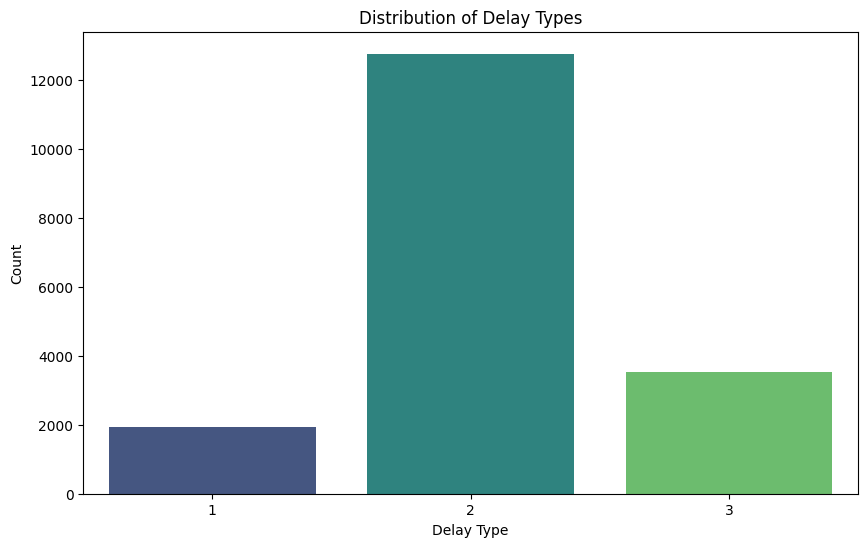

In [25]:
# Visualize this with a whisker plot:
delay_type_counts = df_cleaned['delayType'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=delay_type_counts.index, y=delay_type_counts.values, palette='viridis')
plt.title('Distribution of Delay Types')
plt.xlabel('Delay Type')
plt.ylabel('Count')
plt.show()


**Observation:**
- There is a significant class imbalance (as expected), where the normal delay type (between 6 and 15 minutes) significantly dominates.
- This means we will need to employ stratified sampling during cross-validation (to ensure representative subsets), balanced class weight, and balanced accuracy score to ensure a predictive model that doesn't bias the majority class too much.


In [26]:
# Save down this "df_cleaned" as a parquet file (for separate ML work)
relative_path = os.path.join("..", "data", "df_cleaned.parquet")
df_cleaned.to_parquet(relative_path, index=False)

---
---